# How COVID-19 Impact US Stock Market


## Programming Language: R

## 1. Check data follow OLS assumption and fit OLS model

## Independent & response variables distribution

- <b>Transform data or not</b>  
We can see our independent variables (daily cases, daily deaths, daily vaccinations, cumulative cases, cumulative deaths) are right skewed, but our data observations are large enough (bigger than 50+ data points) so we don't need to transform them to fit OLS. On the other hand, our response variable (close) almost has bell-shape so we don't need to transform either.

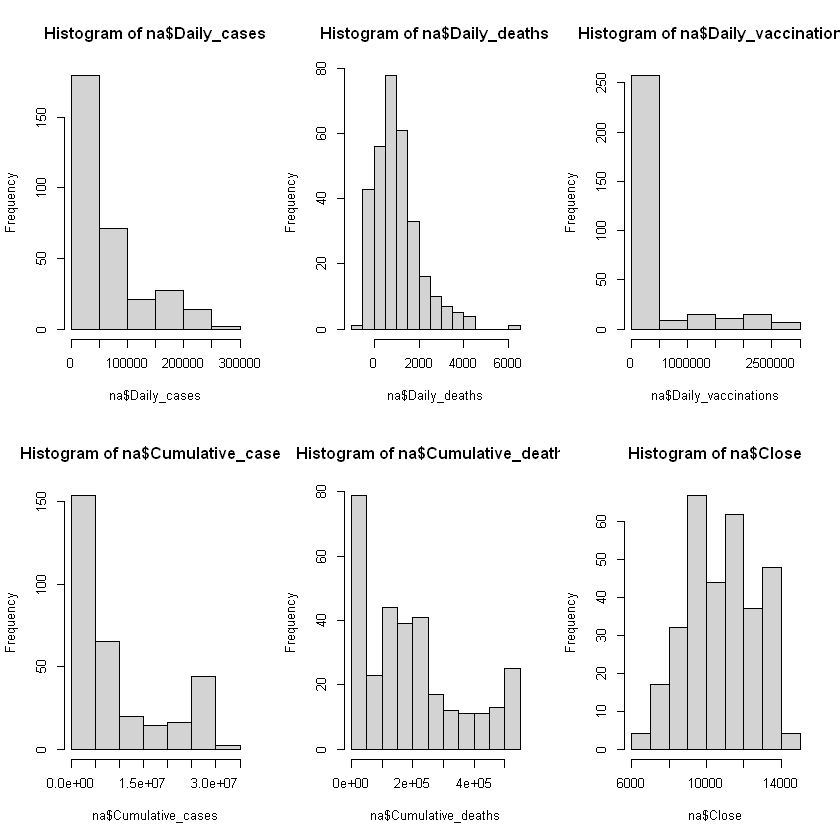

In [4]:
na <- read.csv("NASDAQ2020_2021.csv")  

par(mfrow = c(2,3))
hist(na$Daily_cases)
hist(na$Daily_deaths)
hist(na$Daily_vaccinations)
hist(na$Cumulative_cases)
hist(na$Cumulative_deaths)
hist(na$Close)

## Check VIF (X variables are independent)

- Use 'vif()' to check independent variables having correlation or not. With multicollinearity, we can remove them from our model directly.  
- VIF >= 10 is too high. We can expect Daily_vaccinations(14.6), Cumulative_cases(62.6), and Cumulative_deaths(26.8) will be remove from model if we don't remove manually. (We will use 'stepwise' later.)

In [12]:
library(car)

reg <- lm(Close~ Daily_cases +Daily_deaths +Daily_vaccinations +Cumulative_cases + Cumulative_deaths, data = na)
vif(reg)

Daily_cases       Daily_deaths Daily_vaccinations   Cumulative_cases 
          6.822273           1.929074          14.646821          62.686968 
 Cumulative_deaths 
         26.820132

## Check QQ plot (Errors (residuals) are normally distributed)

- In QQ plot, we can see our data almost fit with the line but only little deviance in front part. Therefore, we can said that our data have normal distribution of residuals so we don't need to transform response variable to fit OLS.

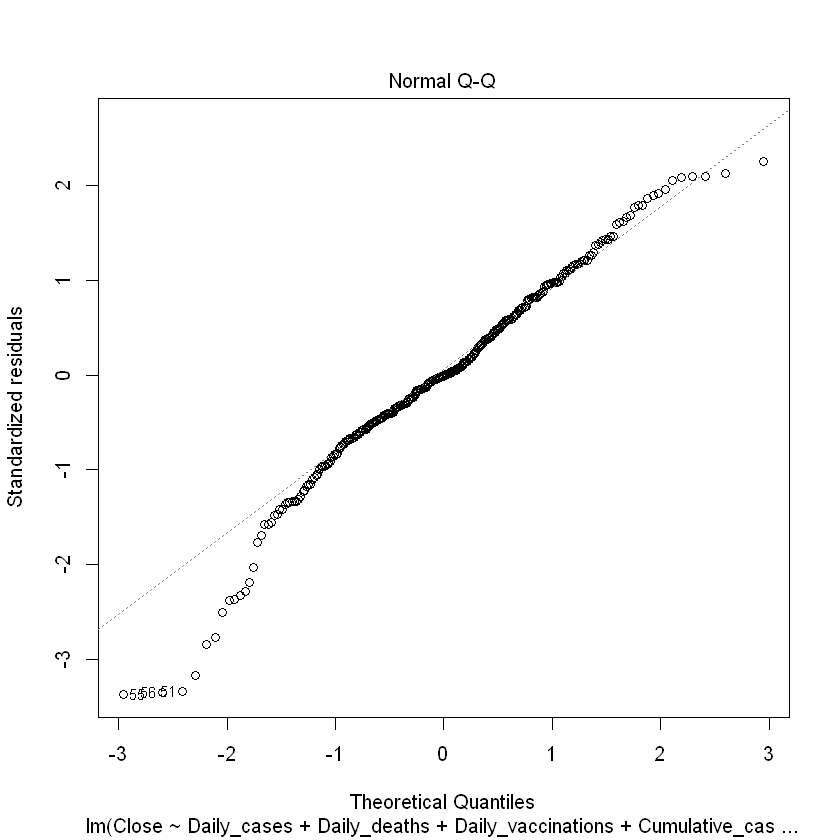

In [4]:
#inspect Normality
#summary(reg)
plot(reg, which = 2)

## Check Heteroskedasticity (Errors (residuals) variance is constant)

- Use <b>Breusch-Pagan test</b> to check the error variance is constant or not. If not, use <b>Weight Least Squares(WLS)</b> to fix it. If p-value of Breusch-Pagan test is siginificant (< 0.05), we can reject the null hypothesis (H0: There is no heteroskedasticity problem, which is homoscedastic).  
- We found the p-value is really low (< 2.2e-16) and the residuals plot also easy to tell uneven residuals.

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric





	studentized Breusch-Pagan test

data:  reg
BP = 94.367, df = 5, p-value < 2.2e-16


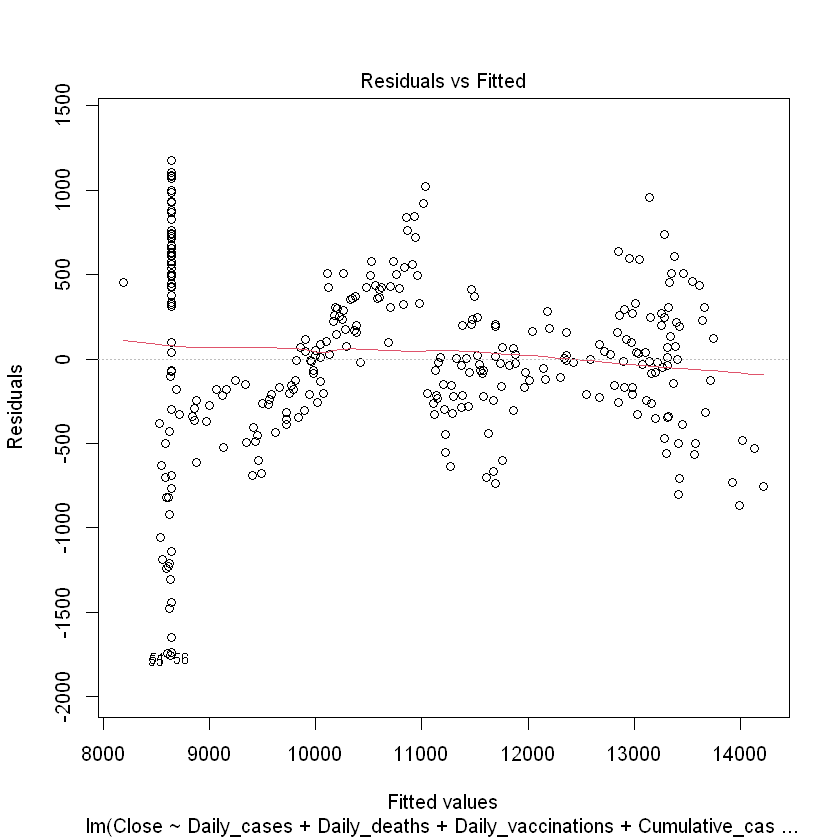

In [15]:
# inspect heteroskedasticity 
library(lmtest)

plot(reg, which = 1)
bptest(reg,data = na)

## Weight Least Squares (WLS)

- Use WLS to fix heteroskedasticity. Then check the residuals plot again. There is no heteroskedasticity issue.

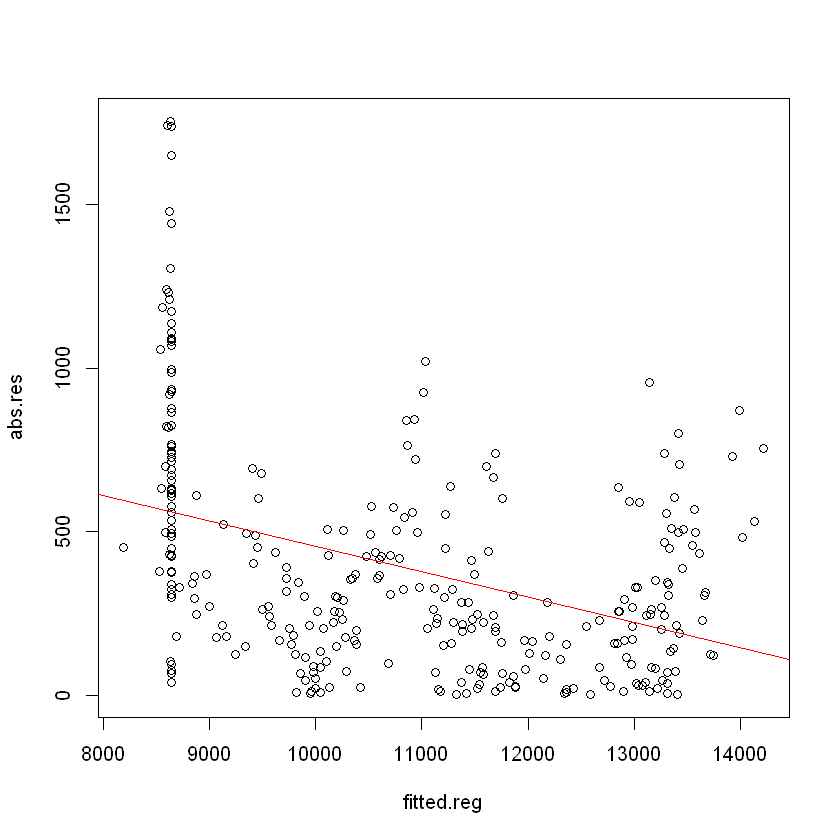

In [20]:
# fit WLS model
abs.res<-abs(residuals(reg))
fitted.reg<- fitted(reg)
lm.abs.res<-lm(abs.res~fitted.reg)
plot(fitted.reg,abs.res)
abline(lm.abs.res,col="red")

wts <- 1/fitted(lm.abs.res)^2
wls.reg<-lm(Close~ Daily_cases +Daily_deaths +Daily_vaccinations +Cumulative_cases + Cumulative_deaths, data=na, weights = wts)
#summary(wls.reg)

## Check serial problem (Observations are independent)

- Use <b>Durbin-Watson test</b> to check if observation is influenced by another. If p-value is siginificant (>0.05), we can reject the null hypothesis (There is no relation among observations). In our case, p-value is very low so we would use <b>lagging</b> to fix serial problem.

In [23]:
dwtest(reg)


	Durbin-Watson test

data:  reg
DW = 0.1854, p-value < 2.2e-16
alternative hypothesis: true autocorrelation is greater than 0


- After using <b>lagging</b> on our outcome variable (Close), we test our new model again and p-value is bigger than 0.05.

In [17]:
library(DataCombine)
close <- slide(na,Var = "Close", NewVar = "Close.L1", slideBy = -1)

fit2 <- lm(Close~Close.L1+Daily_cases+Cumulative_cases+Daily_deaths+Cumulative_deaths+Daily_vaccinations, data = close)
dwtest(fit2)


Remember to put na in time order before running.


Lagging Close by 1 time units.





	Durbin-Watson test

data:  fit2
DW = 2.4408, p-value = 0.9998
alternative hypothesis: true autocorrelation is greater than 0


## Variable Selection

- We use our WLS and Lagging variable to do variable selection. In this project, we use stepwise function to do so.
- Lagging Close, Daily cases, and cumulative deaths are final predictors for our linear model.

In [21]:
# variable selection
wls.reg2 <-lm(Close~ Close.L1+Daily_cases +Daily_deaths +Daily_vaccinations +Cumulative_cases + Cumulative_deaths, 
              data=close, weights = wts)

reduced = lm(Close~1,data = close)
reg.step= step(wls.reg2, scope = list(lower = reduced, upper = wls.reg2), direction="both", test="F")
summary(reg.step)

Start:  AIC=-299.49
Close ~ Close.L1 + Daily_cases + Daily_deaths + Daily_vaccinations + 
    Cumulative_cases + Cumulative_deaths

                     Df Sum of Sq    RSS     AIC   F value  Pr(>F)    
- Daily_deaths        1      0.01 115.71 -301.47    0.0180 0.89346    
- Cumulative_cases    1      0.06 115.76 -301.34    0.1484 0.70037    
- Daily_vaccinations  1      0.18 115.88 -301.01    0.4730 0.49213    
<none>                            115.70 -299.49                      
- Cumulative_deaths   1      1.59 117.29 -297.21    4.2171 0.04087 *  
- Daily_cases         1      1.75 117.45 -296.78    4.6459 0.03191 *  
- Close.L1            1    464.97 580.67  205.04 1233.7483 < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Step:  AIC=-301.47
Close ~ Close.L1 + Daily_cases + Daily_vaccinations + Cumulative_cases + 
    Cumulative_deaths

                     Df Sum of Sq    RSS     AIC   F value  Pr(>F)    
- Cumulative_cases    1      0.07 115.78 -303


Call:
lm(formula = Close ~ Close.L1 + Daily_cases + Cumulative_deaths, 
    data = close, weights = wts)

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-3.14747 -0.24242  0.05943  0.29235  2.35460 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       7.102e+02  1.881e+02   3.777 0.000190 ***
Close.L1          9.220e-01  2.083e-02  44.251  < 2e-16 ***
Daily_cases       7.321e-04  2.042e-04   3.585 0.000392 ***
Cumulative_deaths 5.557e-04  1.832e-04   3.034 0.002619 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6123 on 310 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.9862,	Adjusted R-squared:  0.9861 
F-statistic:  7392 on 3 and 310 DF,  p-value: < 2.2e-16


In [25]:
# final OLS model
close <- close[-1,]
wts <- wts[-1]
reg.final <-lm(Close~ Close.L1 + Daily_cases + Cumulative_deaths, data=close, weights = wts)
#summary(reg.final)


Call:
lm(formula = Close ~ Close.L1 + Daily_cases + Cumulative_deaths, 
    data = close, weights = wts)

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-3.14727 -0.24496  0.06009  0.29320  2.35490 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       7.103e+02  1.883e+02   3.771 0.000195 ***
Close.L1          9.220e-01  2.087e-02  44.183  < 2e-16 ***
Daily_cases       7.308e-04  2.046e-04   3.572 0.000411 ***
Cumulative_deaths 5.546e-04  1.835e-04   3.022 0.002719 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6132 on 309 degrees of freedom
Multiple R-squared:  0.9862,	Adjusted R-squared:  0.986 
F-statistic:  7341 on 3 and 309 DF,  p-value: < 2.2e-16


## OLS Cross-Validation

- Split 80% for training data and 20% for testing.
- After fit the model, we get <b>RMSE is 244.33</b> for linear model.

In [27]:
# OLS cross-validation
set.seed(123)
n = length(close$Close)
z =sample(n,0.8*n)

reg.cv <-lm(Close~ Close.L1 + Daily_cases + Cumulative_deaths, data=close[z,],weights = wts[z])
test.mse.rs <- mean( (close$Close[-z] - predict(reg.cv, close[-z,]) )^2)# 52869.23
rmse.ols = round(sqrt(test.mse.rs),3)
rmse.ols

[1] 244.33

# Ridge

- Build Ridge Regression and LASSO to compare with OLS model.

In [34]:
# Ridge 
library(glmnet)
x = model.matrix(reg.final) 
y = close$Close

Loaded glmnet 4.1-2



- Use 10-Fold to get best lamda: 0.97.

[1] 0.97

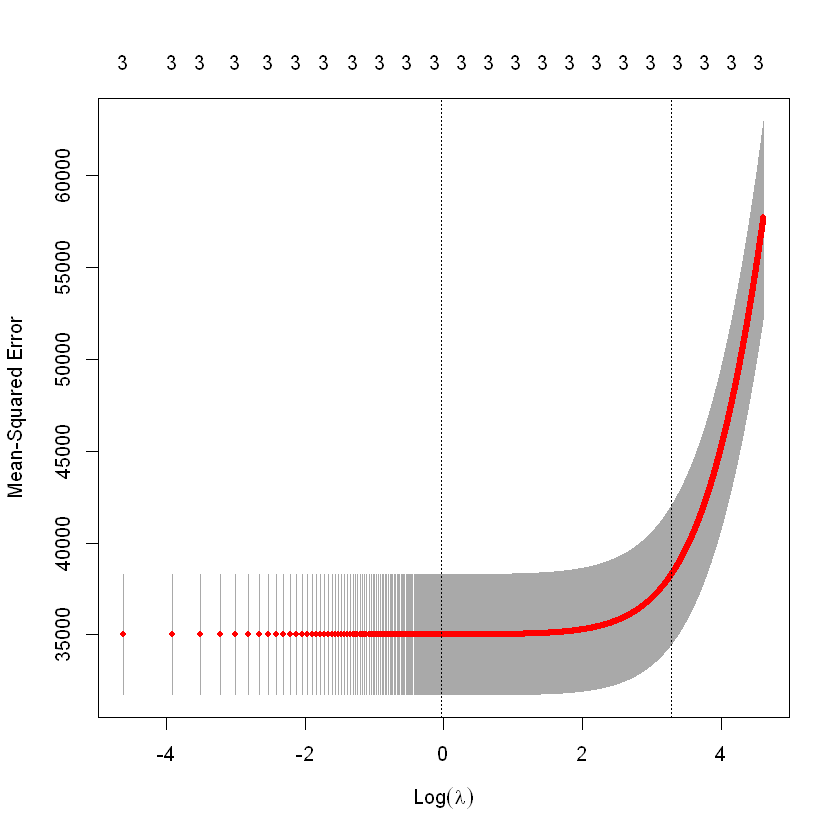

In [35]:
set.seed(123)
ridge.cv = cv.glmnet(x[z,], y[z],alpha =0, lambda = seq(0,100,0.01))
ridge.cv$lambda.min
plot(ridge.cv)

- Use best lamda to fit the model and get model's <b>RMSE is 238.241</b>

In [36]:
ridge = glmnet(x[z,],y[z],alpha =0, lambda = ridge.cv$lambda.min)
Yhat = predict( ridge, ridge.cv$lambda.min, newx = x[-z,] )
ridge.mse = mean((Yhat - y[-z])^2 )
ridge.rmse = round(sqrt(ridge.mse),3)
ridge.rmse

[1] 238.241

## LASSO

- Use 10-Fold to get best lamda: 1.31.

[1] 1.31

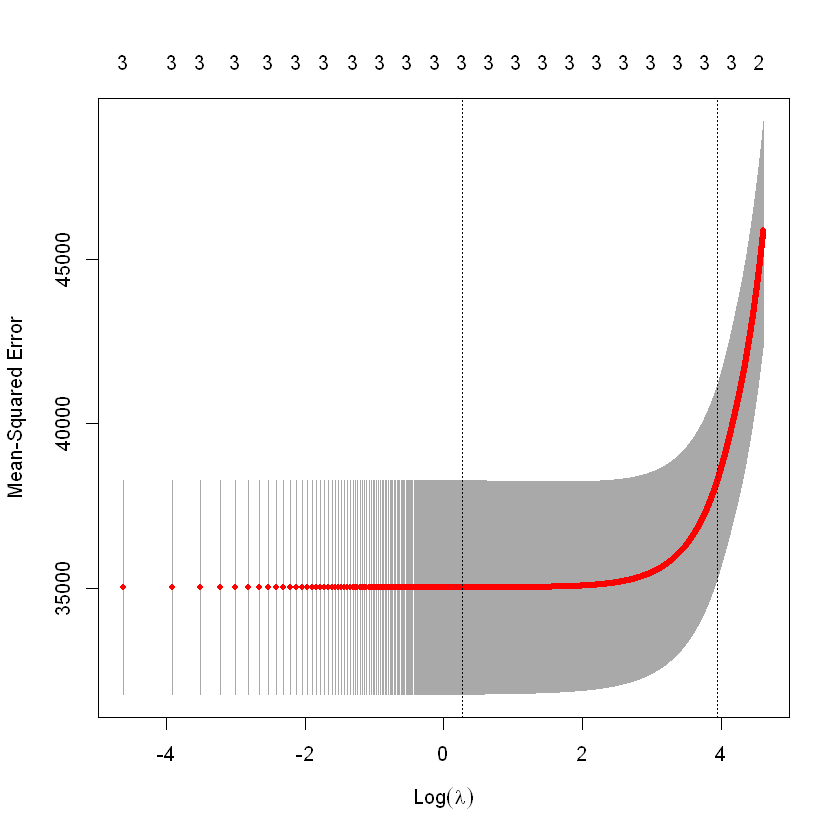

In [37]:
# LASSO
set.seed(123)
lasso.cv = cv.glmnet(x[z,], y[z],alpha =1, lambda = seq(0,100,0.01))
lasso.cv$lambda.min

plot(lasso.cv)

- Use best lamda to fit the model and get model's <b>RMSE is 238.238</b>

In [39]:
lasso = glmnet(x[z,],y[z],alpha =1, lambda = lasso.cv$lambda.min)
Yhat = predict( lasso, lasso.cv$lambda.min, newx = x[-z,] )
lasso.mse = mean((Yhat - y[-z])^2 )
lasso.rmse = round(sqrt(lasso.mse),3)
lasso.rmse

[1] 238.238

In [40]:
rbind(c("OLS RMSE", "Ridge RMSE", "Lasso RMSE"), c(rmse.ols, ridge.rmse,lasso.rmse))

OLS RMSE,Ridge RMSE,Lasso RMSE
244.33,238.241,238.238


# Result

- LASSO is the best model with the lowest RMSE.  
- When the daily cases increases, the stock price also increases. However, this result was conflict to we thought. Usually, we believed the severe pandemic will bring the big issues to our economic, but in our project is not. One of the reason may be we didn't consider that different industry will have different situation during pandemic. Because those industry need to work in-person might be having big influence. Such as medical, school, or vender...etc. On the other hand, those no need to work in-person's industry perhaps won't have big affect. Therefore, if we want to improve our result to be more precise, we need to collect different industy's stock index then run the model again.